In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%%bash

git clone https://github.com/facebookresearch/dinov2.git
cd dinov2

fatal: destination path 'dinov2' already exists and is not an empty directory.


In [ ]:
%%bash
cd dinov2/
# Install conda if it is not already installed.
if ! command -v conda &> /dev/null
then
    wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O Miniconda3.sh
    bash Miniconda3.sh -b -p $HOME/miniconda
    eval "$($HOME/miniconda/bin/conda shell.bash hook)"
    rm -rf Miniconda3.sh
fi

# Export the path to conda to make it accessible
export PATH="$HOME/miniconda/bin:$PATH"

# Create and activate the environment
conda env create -f conda.yaml
conda activate dinov2

--2025-02-11 03:07:59--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154615620 (147M) [application/octet-stream]
Saving to: ‘Miniconda3.sh’

     0K .......... .......... .......... .......... ..........  0% 27.4M 5s
    50K .......... .......... .......... .......... ..........  0% 29.5M 5s
   100K .......... .......... .......... .......... ..........  0% 34.1M 5s
   150K .......... .......... .......... .......... ..........  0%  123M 4s
   200K .......... .......... .......... .......... ..........  0%  269M 3s
   250K .......... .......... .......... .......... ..........  0%  338M 3s
   300K .......... .......... .......... .......... ..........  0%  342M 2s
   350K .......... .......... .......... .......... .

In [ ]:
import torch
import os
import requests
from PIL import Image
from torchvision import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14') # Loading the Large DINO Backbone/feature extractor

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:04<00:00, 277MB/s]


In [ ]:
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [ ]:
patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

pca_animal = "antelope"
folder_path = "drive/MyDrive/side_pose_ap10k/"
total_features  = []
pre_pca_features = []
species_features = []
species = os.listdir(folder_path)
species.remove(".DS_Store")
#print(os.path.exists(folder_path))  # Should return True if the path exists
print(species)
#root, subdir, files = os.walk(folder_path)
#print(f"result of the walk is a root: {root}, subdir: {subdir}, files: {files}")
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Assuming dinov2_vitl14 is defined and imported
# Move the model to the GPU (or CPU if no GPU is available)
dinov2_vitl14.to(device)

with torch.no_grad():
    for specie in species:  # Recursively walk through all subdirectories
        print(specie)
        for file in os.listdir(os.path.join(folder_path, specie)):
          img_path = os.path.join(folder_path, specie, file)
          img = Image.open(img_path).convert('RGB')
          img_t = transform1(img).to(device)

          features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
          features = features_dict['x_norm_patchtokens']
          total_features.append(features)
          if specie == pca_animal:
            pre_pca_features.append(features)
        total_features = torch.cat(total_features, dim=0)
        species_features.append(total_features)
        total_features = []

pre_pca_features = torch.cat(pre_pca_features, dim=0)

#total_features.shape
#torch.tensor(species_features).shape

['spider monkey', 'elephant', 'lion', 'deer', 'cow', 'bison', 'squirrel', 'alouatta', 'skunk', 'horse', 'argali sheep', 'panther', 'jaguar', 'weasel', 'rabbit', 'monkey', 'rhino', 'bobcat', 'buffalo', 'polar bear', 'chimpanzee', 'cheetah', 'wolf', 'beaver', 'mouse', 'king cheetah', 'otter', 'rat', 'marmot', 'tiger', 'panda', 'hamster', 'sheep', 'leopard', 'brown bear', 'zebra', 'giraffe', 'fox', 'dog', 'hippo', 'antelope', 'noisy night monkey', 'moose', 'black bear', 'snow leopard', 'pig', 'raccoon', 'cat', 'gorilla']
Using device: cuda
spider monkey
elephant
lion
deer
cow
bison
squirrel
alouatta
skunk
horse
argali sheep
panther
jaguar
weasel
rabbit
monkey
rhino
bobcat
buffalo
polar bear
chimpanzee
cheetah
wolf
beaver
mouse
king cheetah
otter
rat
marmot
tiger
panda
hamster
sheep
leopard
brown bear
zebra
giraffe
fox
dog
hippo
antelope
noisy night monkey
moose
black bear
snow leopard
pig
raccoon
cat
gorilla


In [ ]:
pre_pca_features.shape

torch.Size([15059, 1024])

In [ ]:
for features in species_features:
  print(features.shape)

torch.Size([12, 1369, 1024])
torch.Size([54, 1369, 1024])
torch.Size([5, 1369, 1024])
torch.Size([26, 1369, 1024])
torch.Size([14, 1369, 1024])
torch.Size([27, 1369, 1024])
torch.Size([52, 1369, 1024])
torch.Size([5, 1369, 1024])
torch.Size([41, 1369, 1024])
torch.Size([10, 1369, 1024])
torch.Size([7, 1369, 1024])
torch.Size([4, 1369, 1024])
torch.Size([14, 1369, 1024])
torch.Size([54, 1369, 1024])
torch.Size([68, 1369, 1024])
torch.Size([13, 1369, 1024])
torch.Size([10, 1369, 1024])
torch.Size([16, 1369, 1024])
torch.Size([15, 1369, 1024])
torch.Size([35, 1369, 1024])
torch.Size([5, 1369, 1024])
torch.Size([20, 1369, 1024])
torch.Size([8, 1369, 1024])
torch.Size([49, 1369, 1024])
torch.Size([60, 1369, 1024])
torch.Size([2, 1369, 1024])
torch.Size([26, 1369, 1024])
torch.Size([45, 1369, 1024])
torch.Size([3, 1369, 1024])
torch.Size([11, 1369, 1024])
torch.Size([14, 1369, 1024])
torch.Size([36, 1369, 1024])
torch.Size([16, 1369, 1024])
torch.Size([14, 1369, 1024])
torch.Size([21, 1369, 

## To perform Quantitative Species Similarity Analysis


In [ ]:
# Dictionary to store the average feature vector for each species
species_avg_vectors = {}

for specie, species_feature in zip(species, species_features):
  num_images = species_feature.shape[0]
  species_feature = species_feature.reshape(num_images, patch_h * patch_w * feat_dim) # flattening output of each image into a vector
  avg_vector = species_feature.mean(axis=0)

  # Store the average feature vector
  species_avg_vectors[specie] = avg_vector

# Get the average feature vector for antelopes
antelope_vector = species_avg_vectors.get("antelope")
if antelope_vector is None:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

# Compute cosine similarity of all species with respect to antelopes
cosine_similarities = []
for specie, avg_vector in species_avg_vectors.items():
    similarity = cosine_similarity(avg_vector.cpu().reshape(1, -1), antelope_vector.cpu().reshape(1, -1))[0][0]
    cosine_similarities.append((specie, similarity))

# Sort species by descending cosine similarity
cosine_similarities.sort(key=lambda x: x[1], reverse=True)

# Print results
for specie, similarity in cosine_similarities:
    print(f"{specie}: {similarity:.4f}")

antelope: 1.0000
deer: 0.8048
sheep: 0.7620
moose: 0.7485
bison: 0.7443
cheetah: 0.7411
giraffe: 0.7375
fox: 0.7313
cow: 0.7251
brown bear: 0.7244
weasel: 0.7056
buffalo: 0.6940
rabbit: 0.6864
wolf: 0.6779
dog: 0.6622
raccoon: 0.6568
pig: 0.6549
skunk: 0.6499
elephant: 0.6387
squirrel: 0.6357
horse: 0.6338
hippo: 0.6278
beaver: 0.6278
argali sheep: 0.6223
mouse: 0.6188
bobcat: 0.6132
otter: 0.6100
rhino: 0.6035
snow leopard: 0.5989
polar bear: 0.5984
tiger: 0.5964
rat: 0.5862
lion: 0.5859
leopard: 0.5851
spider monkey: 0.5793
panda: 0.5764
monkey: 0.5665
jaguar: 0.5500
zebra: 0.5482
chimpanzee: 0.5346
cat: 0.5275
hamster: 0.5135
marmot: 0.5048
king cheetah: 0.4815
alouatta: 0.4501
panther: 0.4501
noisy night monkey: 0.4417
black bear: 0.4211
gorilla: 0.3279


## To perform Qualititative Species Similarity Analysis

In [ ]:
# First Apply PCA to Seperate Background
# sklearn expects 2d array for training
num_images = pre_pca_features.shape[0]
print(pre_pca_features.shape)
#pre_pca_features = pre_pca_features.reshape(num_images * patch_h * patch_w, feat_dim) #(images*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(pre_pca_features.cpu())
pca_features = pca.transform(pre_pca_features.cpu())

torch.Size([15059, 1024])


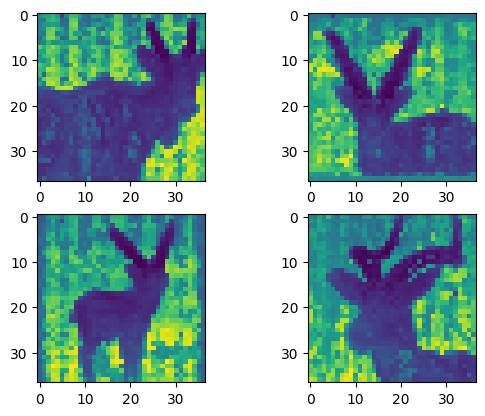

In [ ]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))


plt.show()

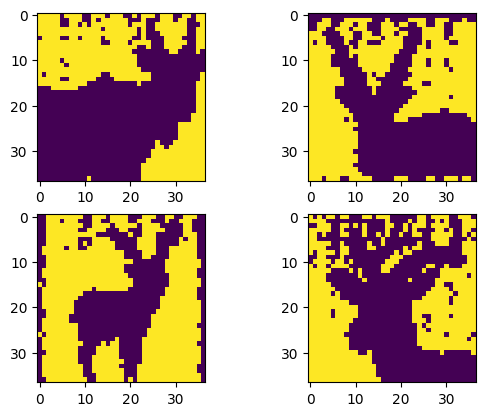

In [ ]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


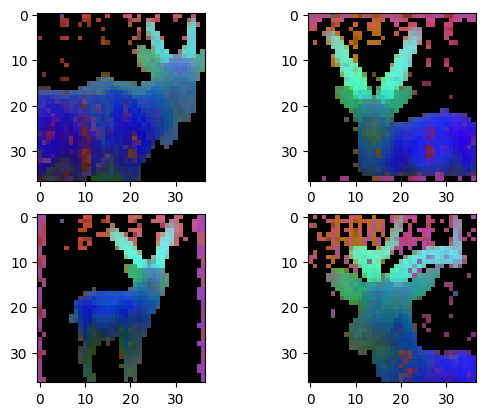

In [ ]:
# 2nd PCA for only foreground patches
pca.fit(pre_pca_features[pca_features_fg].cpu())
pca_features_left = pca.transform(pre_pca_features[pca_features_fg].cpu())

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(len(image_files), patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

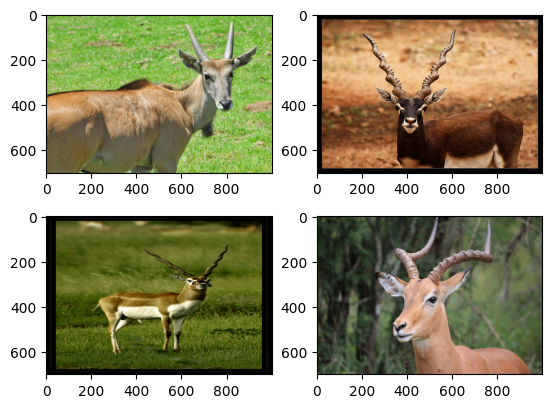

In [ ]:
# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# Loop through the first 4 images
for i, img_file in enumerate(image_files[:4]):
  img_path = os.path.join(subfolder_path, img_file)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()